# Preclinical AIF

In [1]:
import os
import numpy
from matplotlib import pyplot as plt
from matplotlib.transforms import offset_copy
import csv
import seaborn as sns
import pandas as pd
import json
from pathlib import Path

## Background
This preclinical AIF is derived from DCE-MRI data of rats described in the the paper of McGrath et al. (MRM 2009).


## Test data
To create the AIF the parameters of the functional form are copied from Table 1, Model B of the reference. The original data had a temp resolution of 0.5 s and tot acquisition time of 300s. This data was labeled as 'Original_AIF'. 
Permutations of this AIF were used to test the implementations:
- various temporal resolutions: 0.5, 1, 2, 2.5, 5, 7.5 s
- various acquistion times: 3, 5, 7, 10 min
- shifts of the AIF with a temporal resolution of 1.5 s (dt): 0, dt, 2*dt, 5*dt, 2, 5, 10, 18, 31

As we don't expect many errors in implementing the population AIFs, the tolerances were set tight.  
Tolerances: absolute + relative = 0.0001 mM + 0.01 and 0.1 mM + 0.1 for the data with a shift.


## Import data

In [2]:
# Load the meta data
meta = json.load(open("../test/results/results-meta.json"))

In [3]:
# Loop over each entry and collect the dataframe
df = []
for entry in meta:
    if (entry['category'] == 'PopulationAIF') & (entry['method'] == 'preclinical') :
        fpath, fname, category, method, author = entry.values()
        df_entry = pd.read_csv(Path(fpath, fname)).assign(author=author)
        df.append(df_entry)
    
# Concat all entries
df = pd.concat(df)

In [4]:
# label data source
df['source']=''
df.loc[df['label'].str.contains('original'),'source']='original'
df.loc[df['label'].str.contains('acq_time_'),'source']='acq_time'
df.loc[df['label'].str.contains('temp_res'),'source']='temp_res' 
df.loc[df['label'].str.contains('delay'),'source']='delay' 

author_list = df.author.unique()
no_authors = len(author_list)

## Results

### Original AIF

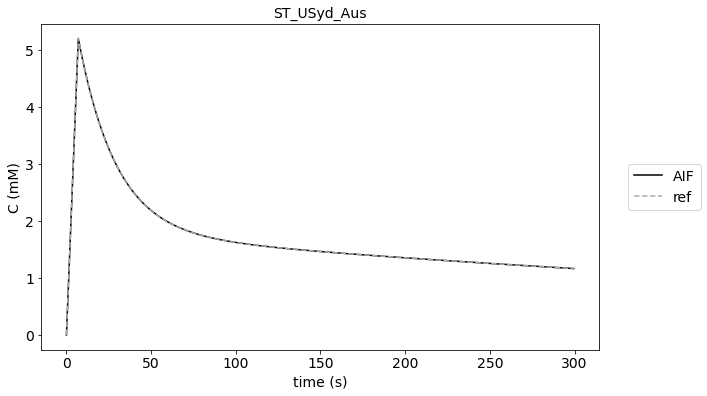

In [5]:
data_original = df[(df['source']=='original')]  

fig, axs = plt.subplots(1, no_authors, sharey='none',figsize=(10,6))

for current_author in range(no_authors):
    plt.subplot(1,no_authors,current_author+1)
    subset_data = data_original[data_original['author'] == author_list[current_author]]
    plt.plot(subset_data.time_ref, subset_data.cb_measured, color='black',label ="AIF")
    plt.plot(subset_data.time_ref, subset_data.aif_ref, color='darkgrey', linestyle='dashed', label='ref')
    
    plt.title(author_list[current_author], fontsize=14)
    plt.xlabel('time (s)', fontsize=14)
    plt.ylabel('C (mM)', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", fontsize=14)


### Different acquisition times

There are no errors for different acquisition times.  
This test data was added to check whether the contributions can work with acquisition times different from the original reference.

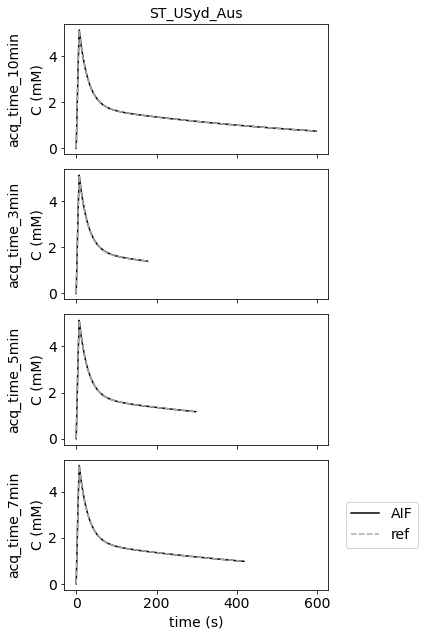

In [6]:
data_acqtime = df[(df['source']=='acq_time')]
acq_list = data_acqtime.label.unique()
no_acq = len(acq_list)

fig, ax = plt.subplots(no_acq, no_authors, sharex='col', sharey='row', figsize=(6,9))

if no_authors > 1:
    for current_acq in range(no_acq):
        for current_author in range(no_authors):
            subset_data = data_acqtime[(data_acqtime['author'] == author_list[current_author]) & (data_acqtime['label'] == acq_list[current_acq])]
            ax[current_acq,current_author].plot(subset_data.time_ref, subset_data.cb_measured, color='black',label ="AIF")
            ax[current_acq,current_author].plot(subset_data.time_ref, subset_data.aif_ref, color='darkgrey', linestyle='dashed', label='ref')

            if current_acq == 0:
                ax[current_acq,current_author].set_title(author_list[current_author], fontsize=14)
            if current_author == 0:
                ax[current_acq,current_author].set_ylabel('C (mM)', fontsize=14)
            if current_acq == no_acq-1:
                ax[current_acq,current_author].set_xlabel('time (s)', fontsize=14)
            ax[current_acq,current_author].tick_params(axis='x', labelsize=12)
            ax[current_acq,current_author].tick_params(axis='y', labelsize=12)

    ax[no_acq-1,no_authors-1].legend(bbox_to_anchor=(1.04,0.5), loc="center left", fontsize=14)

    # add extra labels for rows (example taken from: https://microeducate.tech/row-and-column-headers-in-matplotlibs-subplots/)
    pad = 5
    for a, row in zip(ax[:,0], acq_list):
        a.annotate(row, xy=(0, 0.5), xytext=(-a.yaxis.labelpad - pad, 0),
                    xycoords=a.yaxis.label, textcoords='offset points',
                    ha='right', va='center', rotation=90, fontsize=14)

    
else:
    for current_acq in range(no_acq):
        subset_data = data_acqtime[(data_acqtime['author'] == author_list[current_author]) & (data_acqtime['label'] == acq_list[current_acq])]
        ax[current_acq].plot(subset_data.time_ref, subset_data.cb_measured, color='black',label ="AIF")
        ax[current_acq].plot(subset_data.time_ref, subset_data.aif_ref, color='darkgrey', linestyle='dashed', label='ref')
        ax[current_acq].set_ylabel('C (mM)', fontsize=14)
        
        if current_acq == 0:
            ax[current_acq].set_title(author_list[current_author], fontsize=14)         
        if current_acq == no_acq-1:
            ax[current_acq].set_xlabel('time (s)', fontsize=14)
        ax[current_acq].tick_params(axis='x', labelsize=14)
        ax[current_acq].tick_params(axis='y', labelsize=14)
            
    ax[no_acq-1].legend(bbox_to_anchor=(1.04,0.5), loc="center left", fontsize=14)
    #add extra labels for rows
    pad = 5        
    for a, row in zip(ax, acq_list):
        a.annotate(row, xy=(0, 0.5), xytext=(-a.yaxis.labelpad - pad, 0),
                xycoords=a.yaxis.label, textcoords='offset points',
                ha='right', va='center', rotation=90, fontsize=14)

        
fig.tight_layout()
fig.subplots_adjust(left=0.15, top=0.95)


### Different temporal resolutions

There are no errors for various temporal resolutions  
This test data was added to check whether the contributions can work with temporal resolutions different from the original reference.

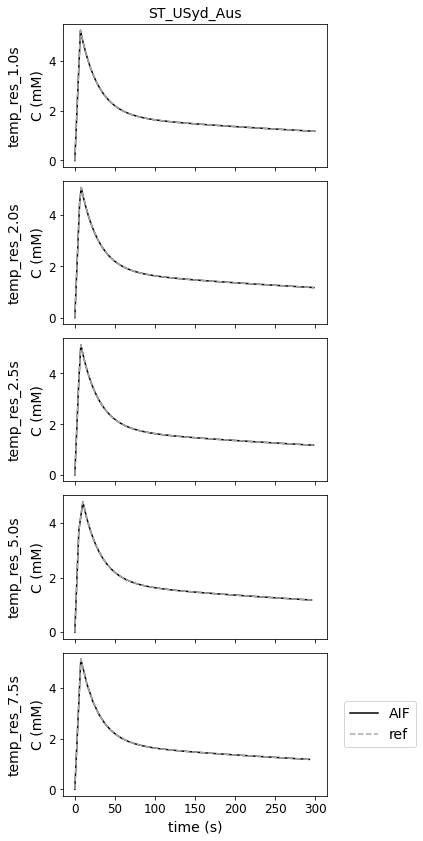

In [7]:
data_res = df[(df['source']=='temp_res')]
res_list = data_res.label.unique()
no_res = len(res_list)

fig, ax = plt.subplots(no_res, no_authors, sharex='col', sharey='row', figsize=(6,12))

if no_authors > 1:
    for current_res in range(no_res):
        for current_author in range(no_authors):
            subset_data = data_res[(data_res['author'] == author_list[current_author]) & (data_res['label'] == res_list[current_res])]
            ax[current_res,current_author].plot(subset_data.time_ref, subset_data.cb_measured, color='black',label ="AIF")
            ax[current_res,current_author].plot(subset_data.time_ref, subset_data.aif_ref, color='darkgrey', linestyle='dashed', label='ref')

            if current_res == 0:
                ax[current_res,current_author].set_title(author_list[current_author], fontsize=14)
            if current_author == 0:
                ax[current_res,current_author].set_ylabel('C (mM)', fontsize=14)
            if current_res == no_res-1:
                ax[current_res,current_author].set_xlabel('time (s)', fontsize=14)
            ax[current_res,current_author].tick_params(axis='x', labelsize=12)
            ax[current_res,current_author].tick_params(axis='y', labelsize=12)

    ax[no_res-1,no_authors-1].legend(bbox_to_anchor=(1.04,0.5), loc="center left", fontsize=14)
    
    #add extra labels for rows
    pad = 5
    for a, row in zip(ax[:,0], res_list):
        a.annotate(row, xy=(0, 0.5), xytext=(-a.yaxis.labelpad - pad, 0),
                    xycoords=a.yaxis.label, textcoords='offset points',
                    ha='right', va='center', rotation=90, fontsize=14)
    
else:
    for current_res in range(no_res):
        subset_data = data_res[(data_res['author'] == author_list[current_author]) & (data_res['label'] == res_list[current_res])]
        ax[current_res].plot(subset_data.time_ref, subset_data.cb_measured, color='black',label ="AIF")
        ax[current_res].plot(subset_data.time_ref, subset_data.aif_ref, color='darkgrey', linestyle='dashed', label='ref')
        ax[current_res].set_ylabel('C (mM)', fontsize=14)
        
        if current_res == 0:
            ax[current_res].set_title(author_list[current_author], fontsize=14)         
        if current_res == no_res-1:
            ax[current_res].set_xlabel('time (s)', fontsize=14)
        ax[current_res].tick_params(axis='x', labelsize=12)
        ax[current_res].tick_params(axis='y', labelsize=12)
    
    #add extra labels for rows
    pad = 5
    for a, row in zip(ax, res_list):
        a.annotate(row, xy=(0, 0.5), xytext=(-a.yaxis.labelpad - pad, 0),
                    xycoords=a.yaxis.label, textcoords='offset points',
                    ha='right', va='center', rotation=90, fontsize=14)

    ax[no_res-1].legend(bbox_to_anchor=(1.04,0.5), loc="center left", fontsize=14)

fig.tight_layout()
fig.subplots_adjust(left=0.15, top=0.95)

### Variations in bolus arrival time

This test data was added to check how contributions deal with a difference in bolus arrival time.
Figures are zoomed on the first 50 s to show the differences in the peak due to differences in bolus arrival time. In this case there was no difference between reference and measured AIFs.

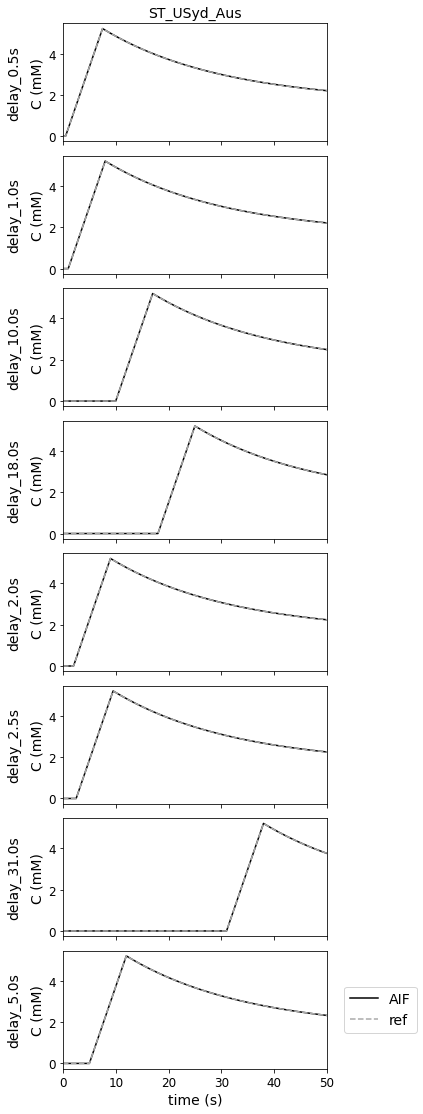

In [8]:
data_delay = df[(df['source']=='delay')]
delay_list = data_delay.label.unique()
no_delay = len(delay_list)

fig, ax = plt.subplots(no_delay, no_authors, sharex='col', sharey='row', figsize=(6,16))

if no_authors > 1:
    for current_delay in range(no_delay):
        for current_author in range(no_authors):
            subset_data = data_delay[(data_delay['author'] == author_list[current_author]) & (data_delay['label'] == delay_list[current_delay])]
            ax[current_delay,current_author].plot(subset_data.time_ref, subset_data.cb_measured, color='black',label ="AIF")
            ax[current_delay,current_author].plot(subset_data.time_ref, subset_data.aif_ref, color='darkgrey', linestyle='dashed', label='ref')

            if current_delay == 0:
                ax[current_delay,current_author].set_title(author_list[current_author], fontsize=14)
            if current_author == 0:
                ax[current_delay,current_author].set_ylabel('C (mM)', fontsize=14)
            if current_delay == no_res-1:
                ax[current_delay,current_author].set_xlabel('time (s)', fontsize=14)

            ax[current_delay,current_author].set_xlim([0, 50])
            ax[current_delay,current_author].tick_params(axis='x', labelsize=12)
            ax[current_delay,current_author].tick_params(axis='y', labelsize=12)

    ax[no_delay-1,no_authors-1].legend(bbox_to_anchor=(1.04,0.5), loc="center left", fontsize=14)

    # add extra labels for rows
    pad = 5
    for a, row in zip(ax[:,0], delay_list):
        a.annotate(row, xy=(0, 0.5), xytext=(-a.yaxis.labelpad - pad, 0),
                    xycoords=a.yaxis.label, textcoords='offset points',
                    ha='right', va='center', rotation=90, fontsize=14)
    
else:
    for current_delay in range(no_delay):
        subset_data = data_delay[(data_delay['author'] == author_list[current_author]) & (data_delay['label'] == delay_list[current_delay])]
        ax[current_delay].plot(subset_data.time_ref, subset_data.cb_measured, color='black',label ="AIF")
        ax[current_delay].plot(subset_data.time_ref, subset_data.aif_ref, color='darkgrey', linestyle='dashed', label='ref')
        ax[current_delay].set_ylabel('C (mM)', fontsize=14)
        
        if current_delay == 0:
            ax[current_delay].set_title(author_list[current_author], fontsize=14)         
        if current_delay == no_delay-1:
            ax[current_delay].set_xlabel('time (s)', fontsize=14)
        ax[current_delay].tick_params(axis='x', labelsize=12)
        ax[current_delay].tick_params(axis='y', labelsize=12)
            
        ax[current_delay].set_xlim([0, 50])
    
    #add extra labels for rows
    pad = 5
    for a, row in zip(ax, delay_list):
        a.annotate(row, xy=(0, 0.5), xytext=(-a.yaxis.labelpad - pad, 0),
                    xycoords=a.yaxis.label, textcoords='offset points',
                    ha='right', va='center', rotation=90, fontsize=14)

    ax[no_delay-1].legend(bbox_to_anchor=(1.04,0.5), loc="center left", fontsize=14)

fig.tight_layout()
fig.subplots_adjust(left=0.15, top=0.95)

## Notes
Additional notes/remarks

### References
McGrath et al. "Comparison of Model-Based Arterial Input Functions forDynamic Contrast-Enhanced MRI in Tumor Bearing Rats", Magn Reson Med (2009), DOI: 10.1002/mrm.21959